# U-net   Dataset: 2018 Data Science Bowl

### Helya Haji & Shamim Najafi

In [1]:
import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

seed = 42
np.random.seed(seed)

TRAIN_PATH = r"E:\\New folder\\stage1_train (1)"
TEST_PATH = r"E:\\New folder\\stage1_test (1)"

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Initialize arrays to store training images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img_path = os.path.join(path, 'images', f'{id_}.png')
    mask_path = os.path.join(path, 'masks')

    # Check if image file exists
    if not os.path.exists(img_path):
        print(f"Image file not found: {img_path}")
        continue

    # Load and resize the image
    img = imread(img_path)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img

    # Initialize an empty mask
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

    # Check if the mask directory exists and is not empty
    if os.path.exists(mask_path) and len(os.listdir(mask_path)) > 0:
        # Load and combine masks
        for mask_file in os.listdir(mask_path):
            mask_ = imread(os.path.join(mask_path, mask_file))
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
    else:
        print(f"No mask files found in path: {mask_path}")

    # Store the mask in Y_train
    Y_train[n] = mask

print("Finished processing all images and masks!")


Resizing training images and masks


100%|██████████| 670/670 [02:36<00:00,  4.28it/s]

Finished processing all images and masks!


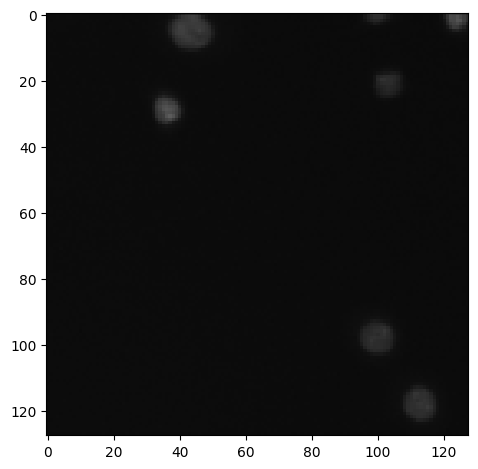

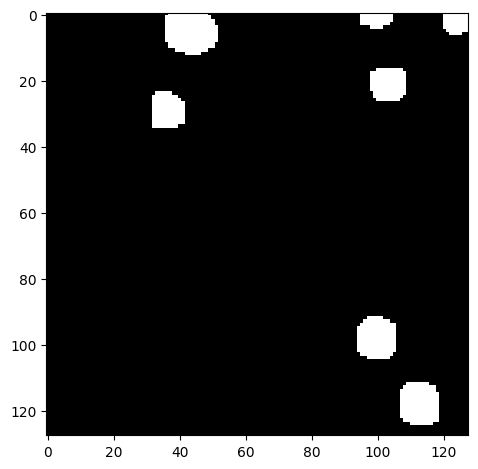

In [2]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

In [3]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [4]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
 kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
 kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', 
kernel_initializer='he_normal', padding='same')(c5)

In [5]:
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', 
padding='same')(c9)

In [6]:
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [7]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Define the log directory for TensorBoard
log_dir = r"E:\\New folder\\logs"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# Create a ModelCheckpoint callback to save the best model during training
checkpointer = ModelCheckpoint('model_for_nuclei.keras', 
                                verbose=1, save_best_only=True)

# Define other callbacks
callbacks = [
    EarlyStopping(patience=2, monitor='val_loss'),
    TensorBoard(log_dir=log_dir)
]

# Fit the model
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25, 
                    callbacks=[checkpointer] + callbacks)


Epoch 1/25


C:\Users\Helya\AppData\Roaming\Python\Python311\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.7437 - loss: 0.6672
Epoch 1: val_loss improved from inf to 0.42678, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.7438 - loss: 0.6657 - val_accuracy: 0.7838 - val_loss: 0.4268
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.7883 - loss: 0.3985
Epoch 2: val_loss improved from 0.42678 to 0.23712, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.7893 - loss: 0.3972 - val_accuracy: 0.9100 - val_loss: 0.2371
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9134 - loss: 0.2260
Epoch 3: val_loss improved from 0.23712 to 0.14721, saving model to model_for_nuclei.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9138 - loss: 0.2251 - val_accuracy: 0.9463 - val_loss: 0.1472
Epoch 4/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9447 - loss: 0.1443
Epoch 4: val_loss improved from 0.14721 to 0.1

Resizing test images


100%|██████████| 65/65 [00:00<00:00, 75.17it/s]


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


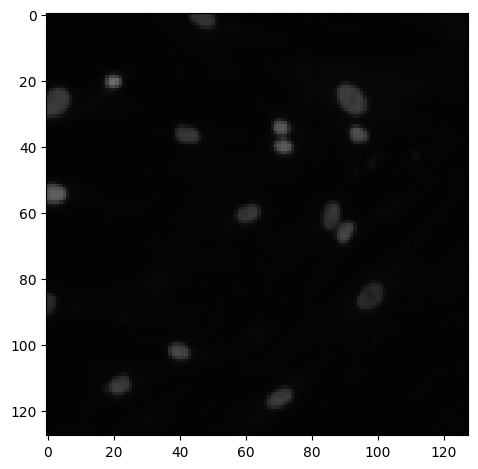

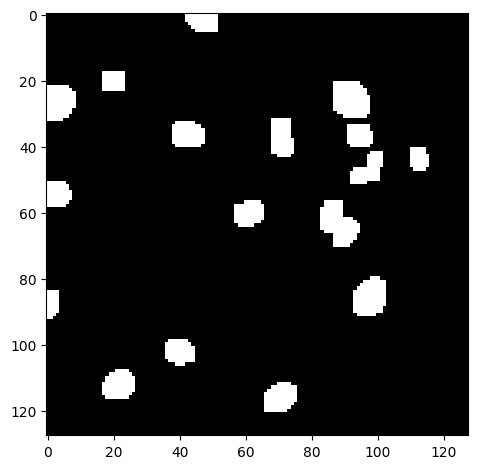

c:\Users\Helya\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:158: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


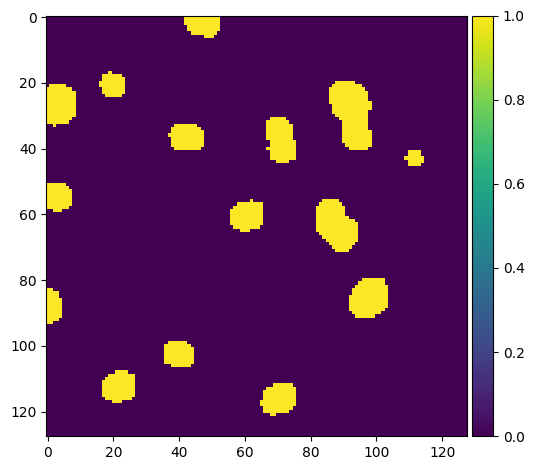

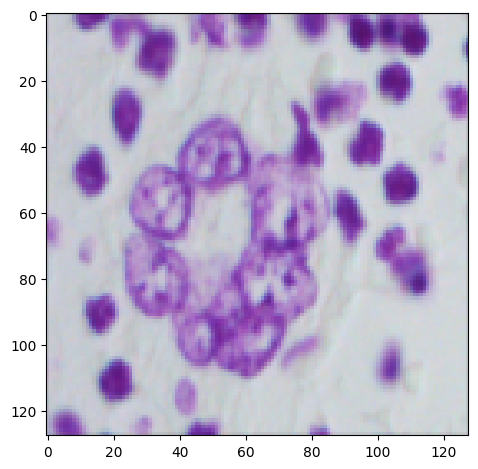

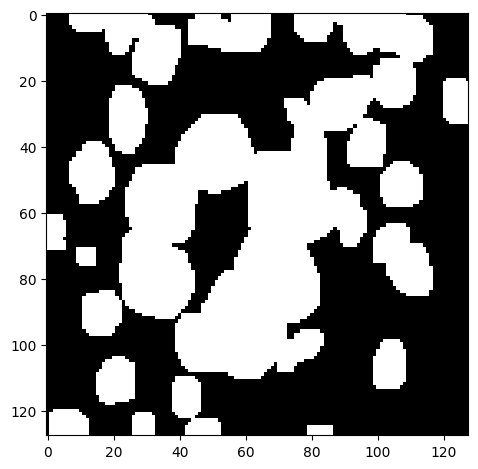

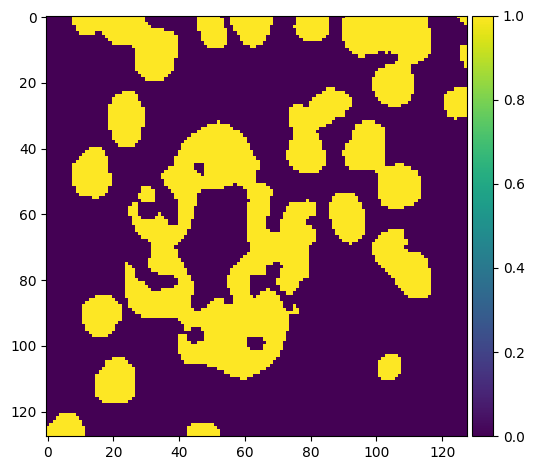

In [9]:
# Define the path for test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

print('Resizing test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img_path = os.path.join(path, 'images', f'{id_}.png')
    
    # Check if the image exists
    if os.path.exists(img_path):
        img = imread(img_path)[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
    else:
        print(f"Test image not found: {img_path}")

# Now you can run predictions
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold the predictions for visualization
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [10]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

print(f'Test Accuracy: {test_accuracy}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7494 - loss: 0.9081
Test Accuracy: 0.7414541244506836
